<a href="https://colab.research.google.com/github/prathameshk30/NLP-based-Information-retrieval/blob/main/NLP_Information_retreival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz
!pip install -U git+https://github.com/JonasTriki/inf368-exercise-3-coordle.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.6/500.6 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for en-core-sci-lg: filename=en_core_sci_lg-0.2.4-py3-none-any.whl size=501343146 sha256=8a636bc678b60c60fcf54147aa49cfb350de845204d81da76c1338c878fb140b
  Stored in directory: /root/.cache/pip/wheels/66/da/d2/71fb4c90c568621f8302ba0924a9097e73f9f4d9779ba0477d
Successfully built en-core-sci-lg
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/JonasTriki/inf368-exercise-3-coordle.git to /tmp/pip-req-build-a0pbdodd
  Running command git clone --filter=blob:none --quiet https://github.com/JonasTriki/inf368-exercise-3-coordle.git /tmp/pip-req-build-a0pbdodd
  Resolved https://github.com/JonasTriki/inf368-exercise-3-coordle.git to commit d31951244949ab9042d8af168c6a144b7cec6e7e
  P

In [19]:
import numpy as np
import pandas as pd
import os
import json
import time
import glob
import re
import sys
import collections
import pandas as pd
pd.options.display.max_colwidth = 10000
import torch
import torch.nn as nn
import numpy as np
import time
from torch.utils.data import DataLoader
# from coordle.utils import clean_text
# from coordle.backend import QueryAppenderIndex

In [20]:
dir_path='/content/drive/MyDrive/NLP/Information Retreival'

In [21]:
# Load the trained Gensim model

model_path = os.path.join(dir_path, 'gensim-word2vec-model', 'cord-19-w2v.model_ver_2')

In [22]:
df = pd.read_csv(dir_path+'/covid_abstracts.csv')
df.head(2)

,title,abstract,url
0,Real-World Experience with COVID-19 Including Direct COVID-19 Antigen Testing and Monoclonal-Antibody Bamlanivimab in a Rural Critical Access Hospital in South Dakota,This article summarizes the experiences of COVID-19 patients diagnosed and treated at Faulkton Area Medical Center FAMC a rural critical access facility in South Dakota during three periods of COVID-19 Retrospective chart review was used to classify COVID-19 patients into three groups by time frame 1 Early March 2020 with the arrival of COVID-19 to South Dakota until August 31 2020 2 September 1 2020 with the use of rapid result direct COVID-19 virus antigen testing through November 24 2020 which took place during our COVID-19 surge and 3 November 25 2020 the start of bamlanivimab infusions on high-risk patients with COVID-19 throughFebruary15 2021 the cutoff for this review Faulk County had higher COVID-19 case rates and COVID-19 death rates than South Dakota in general Final review of the data showed stable overall hospitalization rates at FAMC in each of these time periods Data was broken down by age and not other demographics due to small patient population size and limited ability to blind data Breakdown of the data showed the hospitalization rates in the 60-90 age groups did decrease from 33 3 percent to 22 2 percent following bamlanivimab use Absolute risk reduction 11 1 percent Relative risk reduction of hospitalization from November 25 2020 through February 15 2021 compared to September 1 2020 through November 25 2020 was 0 33 odds ratio 0 57 CI 95 percent 0 21-1 58 This is not statistically significant NNT 9 Data is limited by small overall numbers of patients and lack of data in Faulkton area residents who sought medical care outside the local facility,https://pubmed.ncbi.nlm.nih.gov/35008137
1,Successful outcome of pre-engraftment COVID-19 in an HCT patient impact of targeted therapies and cellular immunity,Coronavirus disease 2019 COVID-19 caused by severe acute respiratory syndrome coronavirus 2 SARS-CoV-2 infection has emerged as a global pandemic that upended existing protocols and practices including those for allogeneic hematopoietic stem cell transplantation HCT Here we describe the successful clinical course and multiple key interventions administered to an acute lymphoblastic leukemia patient who tested SARS-CoV-2 positive by RT-PCR on day -1 of matched unrelated donor SARS-CoV-2 IgG negative T-cell-replete HCT This experience allowed for implementing a virologic and immunomonitoring panel to characterize the impact of SARS-CoV-2 on the recipient s nascent humoral and cellular immune response The finding of robust functional and persistent levels of SARS-CoV-2 specific T-cells starting early after transplant was unexpected and in combination with the clinical strategy may have contributed to the favorable outcome Additionally it is plausible that pre-existing cross-reactive endemic coronavirus immunity in the allogeneic graft reduced recipient susceptibility to COVID-19 disease This case supports the critical role that T-cell responses may play in mitigating SARS-CoV-2 infection even in the context of transplant immunosuppression in which reconstitution of humoral response is commonly delayed Interventional approaches to transfer SARS-CoV-2-specific cellular immunity such as HCT donor vaccination and adaptive cellular therapy could be of benefit,https://pubmed.ncbi.nlm.nih.gov/35008104


## Combining the Title and abstract 

In [23]:
df['text']=df['title']+'. '+df['abstract']
df.head(2)

,title,abstract,url,text
0,Real-World Experience with COVID-19 Including Direct COVID-19 Antigen Testing and Monoclonal-Antibody Bamlanivimab in a Rural Critical Access Hospital in South Dakota,This article summarizes the experiences of COVID-19 patients diagnosed and treated at Faulkton Area Medical Center FAMC a rural critical access facility in South Dakota during three periods of COVID-19 Retrospective chart review was used to classify COVID-19 patients into three groups by time frame 1 Early March 2020 with the arrival of COVID-19 to South Dakota until August 31 2020 2 September 1 2020 with the use of rapid result direct COVID-19 virus antigen testing through November 24 2020 which took place during our COVID-19 surge and 3 November 25 2020 the start of bamlanivimab infusions on high-risk patients with COVID-19 throughFebruary15 2021 the cutoff for this review Faulk County had higher COVID-19 case rates and COVID-19 death rates than South Dakota in general Final review of the data showed stable overall hospitalization rates at FAMC in each of these time periods Data was broken down by age and not other demographics due to small patient population size and limited ability to blind data Breakdown of the data showed the hospitalization rates in the 60-90 age groups did decrease from 33 3 percent to 22 2 percent following bamlanivimab use Absolute risk reduction 11 1 percent Relative risk reduction of hospitalization from November 25 2020 through February 15 2021 compared to September 1 2020 through November 25 2020 was 0 33 odds ratio 0 57 CI 95 percent 0 21-1 58 This is not statistically significant NNT 9 Data is limited by small overall numbers of patients and lack of data in Faulkton area residents who sought medical care outside the local facility,https://pubmed.ncbi.nlm.nih.gov/35008137,Real-World Experience with COVID-19 Including Direct COVID-19 Antigen Testing and Monoclonal-Antibody Bamlanivimab in a Rural Critical Access Hospital in South Dakota. This article summarizes the experiences of COVID-19 patients diagnosed and treated at Faulkton Area Medical Center FAMC a rural critical access facility in South Dakota during three periods of COVID-19 Retrospective chart review was used to classify COVID-19 patients into three groups by time frame 1 Early March 2020 with the arrival of COVID-19 to South Dakota until August 31 2020 2 September 1 2020 with the use of rapid result direct COVID-19 virus antigen testing through November 24 2020 which took place during our COVID-19 surge and 3 November 25 2020 the start of bamlanivimab infusions on high-risk patients with COVID-19 throughFebruary15 2021 the cutoff for this review Faulk County had higher COVID-19 case rates and COVID-19 death rates than South Dakota in general Final review of the data showed stable overall hospitalization rates at FAMC in each of these time periods Data was broken down by age and not other demographics due to small patient population size and limited ability to blind data Breakdown of the data showed the hospitalization rates in the 60-90 age groups did decrease from 33 3 percent to 22 2 percent following bamlanivimab use Absolute risk reduction 11 1 percent Relative risk reduction of hospitalization from November 25 2020 through February 15 2021 compared to September 1 2020 through November 25 2020 was 0 33 odds ratio 0 57 CI 95 percent 0 21-1 58 This is not statistically significant NNT 9 Data is limited by small overall numbers of patients and lack of data in Faulkton area residents who sought medical care outside the local facility
1,Successful outcome of pre-engraftment COVID-19 in an HCT patient impact of targeted therapies and cellular immunity,Coronavirus disease 2019 COVID-19 caused by severe acute respiratory syndrome coronavirus 2 SARS-CoV-2 infection has emerged as a global pandemic that upended existing protocols and practices including those for allogeneic hematopoietic stem cell transplantation HCT Here we describe the successful 

### Creating  class

In [24]:
# Extract English only texts
eng_texts = df['text'].values

In [ ]:
# Implement the data interator for Word2Vec
class CORDDataIteratorWord2Vec():
    def __init__(self, texts: np.ndarray):
        self.texts = texts
    
    def __iter__(self):
        for text in self.texts:
            sentences = nltk.tokenize.sent_tokenize(text)
            cleaned_sentences = [clean_text(sent) for sent in sentences]
            for sentence in cleaned_sentences:
                yield sentence

In [ ]:
# Implement the epoch saver for Word2Vec
class EpochSaver():
    '''Callback to save model after each epoch.'''

    def __init__(self, output_dir: str, prefix: str, start_epoch: int = 1):
        self.output_dir = output_dir
        self.prefix = prefix
        self.epoch = start_epoch

    def on_epoch_end(self, model):
        output_path = join_path(self.output_dir, f'{self.prefix}_epoch_{self.epoch}.model')
        model.save(output_path)
        self.epoch += 1

### After we have defined these two classes, we train the model in three steps:

#### Initialize Word2Vec model
#### Build Word2Vec vocabulary
#### Train the model

In [ ]:
from gensim import models
import tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
cord_sentences = CORDDataIteratorWord2Vec(eng_texts)
w2v_saved_models_dir = dir_path+'/models-word2vec'
saved_models_prefix = 'model'

# 1. Setup initial model
w2v_model = models.Word2Vec(
    min_count=5, ## Changed min count from 20 to 5 in second iteration.
    window=2,
    vector_size=300,
    negative=5,
    callbacks=[EpochSaver(w2v_saved_models_dir, saved_models_prefix)]
)

# 2. Build vocabulary
w2v_model.build_vocab(cord_sentences)

# 3. Train model
w2v_model.train(
    cord_sentences,
    total_examples=w2v_model.corpus_count,
    epochs=20,
    report_delay=30
)

(26497202, 29328660)

In [ ]:
w2v_model.save(model_path) # Save the model

In [ ]:
w2v_model = models.Word2Vec.load(model_path)  # open the model

In [ ]:
w2v_model.wv.most_similar('covid') # checking the words more similiar to covid

[('covid19', 0.5007758736610413),
 ('term', 0.36903080344200134),
 ('postcovid19', 0.3542958199977875),
 ('imagined', 0.3471318781375885),
 ('postcovid', 0.30385762453079224),
 ('sixmonth', 0.29243603348731995),
 ('covidrelated', 0.2911430597305298),
 ('run', 0.2908444106578827),
 ('noncovid', 0.28789523243904114),
 ('covid19related', 0.281233549118042)]

In [ ]:
#Words to compute cosine similarity over  
word1 = 'china'
word2 = 'wuhan'

#Get the word embeddings 
embedding1 = w2v_model.wv[word1]
embedding2 = w2v_model.wv[word2]

In [ ]:
#Compute the cosine similarity and print the results 
cosineSimilarity = np.sum(embedding1*embedding2) / (np.sqrt(np.sum(np.square(embedding1)))*np.sqrt(np.sum(np.square(embedding2))))
print("Word1: "+word1+" --- Word2: "+word2)
print("Cosine similarity: "+ str(cosineSimilarity))

Word1: china --- Word2: wuhan
Cosine similarity: 0.3657138


##### Our cosine similarity score is very less ! We can train our word 2 vec model for better understanding the word using different hyperparameter.

##### Changing the vector dimesion from 250 to 300. Changing the min count from 20 to 5 ( this means sentences having words less than 5 will not be considered). 

In [ ]:
#Compute the cosine similarity and print the results 
cosineSimilarity = np.sum(embedding1*embedding2) / (np.sqrt(np.sum(np.square(embedding1)))*np.sqrt(np.sum(np.square(embedding2))))
print("Word1: "+word1+" --- Word2: "+word2)
print("Cosine similarity: "+ str(cosineSimilarity))

Word1: china --- Word2: wuhan
Cosine similarity: 0.37949038


##### Still marginal improvement in cosine score

In [ ]:
# To demonstrate how the search engine works, we index on a subset of the documents in the dataframe.
ai_index = QueryAppenderIndex(w2v_model.wv.most_similar, n_similars=1)
ai_index.build_from_df(
    df,
    'title',
    'url',
    'text',
    verbose=True, 
    use_multiprocessing=True,
    workers=-1
)

Text cleaning initilized on 12 workers


Adding to index: 100%|██████████| 10000/10000 [00:05<00:00, 1842.33it/s]


In [ ]:
def search_and_show(query: str, max_results: int = 3, max_body_length: int = 500):
    '''Searches using the AI Index and shows the result
    
    Args:
        query: Search query
        max_results: Max results to show for each query    
    '''
    docs, scores, errmsgs = ai_index.search(query)
    if errmsgs:
        print('The following errors occurred:', errmsgs)
    else:
        if len(docs) == 0:
            print('Sorry, no results found.')
        else:
            for doc, score in zip(docs[:max_results], scores[:max_results]):
                print(f'{doc.uid}  {str(doc.title)[:70]:<70}  {score:.4f}')
                print('---')

In [ ]:
search_and_show('latest research')

Rapid Counseling  as a new breakthrough  An alternative approach for patients with COVID-19  https://pubmed.ncbi.nlm.nih.gov/34861958                                0.2950
---
---
Identification of Research Priorities during the COVID-19 Pandemic  Implications for Its Management  https://pubmed.ncbi.nlm.nih.gov/34948715                                0.2694
---
---
Advancing Clinical Trials in Nursing Homes  A Proposed Roadmap to Success  https://pubmed.ncbi.nlm.nih.gov/34953784                                0.1953
---
---


##### The word 2 vec model does understand the context of the given sentences. But we can try some other model to check if they give us some or different result.

## Using BERT for creating the sentence embeddings



In [25]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [26]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
from transformers import BertModel, BertTokenizer

model = BertModel.from_pretrained('bert-base-uncased',
           output_hidden_states = True,)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 2. Create contextual embeddings

#### We have to put the input text into a specific format that BERT can read. Mainly we add the [CLS] to the beginning and [SEP] to the end of the input. Then we convert the tokenized BERT input to the tensor format.

In [29]:
def bert_text_preparation(text, tokenizer):
  """
  Preprocesses text input in a way that BERT can interpret.
  """
  encodings = tokenizer(text, 
    padding='max_length', # pad the texts to the maximum length (so that all outputs have the same length)
    max_length=512, # return max lenght 512
    truncation=True)

  
  tokenized_text=[]
  for tokens in encodings['input_ids']:
    tokenized_text.append((tokenizer.convert_ids_to_tokens(tokens)))

  # convert inputs to tensors
  tokens_tensor = torch.tensor([encodings['input_ids']])
  segments_tensor = torch.tensor([encodings['attention_mask']])

  return tokenized_text, tokens_tensor, segments_tensor

In [30]:
bert_text_preparation(eng_texts[2], tokenizer)

(['[CLS]',
  'the',
  'impact',
  'of',
  'co',
  '##vid',
  '-',
  '19',
  'on',
  'on',
  '##cology',
  'professionals',
  '-',
  'one',
  'year',
  'on',
  'lessons',
  'learned',
  'from',
  'the',
  'es',
  '##mo',
  'res',
  '##ili',
  '##ence',
  'task',
  'force',
  'survey',
  'series',
  '.',
  'background',
  'co',
  '##vid',
  '-',
  '19',
  'has',
  'had',
  'a',
  'significant',
  'impact',
  'on',
  'the',
  'well',
  '-',
  'being',
  'and',
  'job',
  'performance',
  'of',
  'on',
  '##cology',
  'professionals',
  'globally',
  'the',
  'european',
  'society',
  'for',
  'medical',
  'on',
  '##cology',
  'es',
  '##mo',
  'res',
  '##ili',
  '##ence',
  'task',
  'force',
  'collaboration',
  'set',
  'out',
  'to',
  'investigate',
  'and',
  'monitor',
  'well',
  '-',
  'being',
  'since',
  'co',
  '##vid',
  '-',
  '19',
  'in',
  'relation',
  'to',
  'work',
  'lifestyle',
  'and',
  'support',
  'factors',
  'in',
  'on',
  '##cology',
  'professionals',
  

#### In order to obtain the actual BERT embeddings, we take preprocessed input text, which now is represented by tensors, put it into our pre-trained BERT model.Which vector works best as a contextualized embedding? I would think it depends on the task. The original paper that proposed BERT examines six choices. I go with one of these choice that worked well in their experiments, which is the sum of the last four layers of the model.

#### BERT Embedding :-
#### Trail 1- with stacking all the layer

In [31]:
def get_bert_embeddings(tokens_tensor, segments_tensor, model):
    """
    Obtains BERT embeddings for tokens, in context of the given sentence.
    """
    # gradient calculation id disabled
    with torch.no_grad():
      # obtain hidden states
      outputs = model(tokens_tensor, segments_tensor)
      hidden_states = outputs[2]

    # concatenate the tensors for all layers
    # use "stack" to create new dimension in tensor
    token_embeddings = torch.stack(hidden_states, dim=0)

    # remove dimension 1, the "batches"
    token_embeddings = torch.squeeze(token_embeddings, dim=1)

    # swap dimensions 0 and 1 so we can loop over tokens
    token_embeddings = token_embeddings.permute(1,0,2)

    # intialized list to store embeddings
    token_vecs_sum = []

    # "token_embeddings" is a [Y x 12 x 768] tensor
    # where Y is the number of tokens in the sentence

    # loop over tokens in sentence
    for token in token_embeddings:

        # "token" is a [12 x 768] tensor

        # sum the vectors from the last four layers
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum.append(sum_vec)

    return token_vecs_sum

In [34]:
from collections import OrderedDict
import pickle
import gc
import tqdm

# Create a list of documents as memory won't be able to handle all of the data in a list in one go 

list_eng_text=[eng_texts[7501:10000]]

# iterating over the list of documents

count=4
for eng_text in tqdm.tqdm(list_eng_text):
  context_embeddings = []
  context_tokens = []
  for sentence in (eng_text):
    tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(sentence, tokenizer)
    list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)

    # make ordered dictionary to keep track of the position of each word
    tokens = OrderedDict()

    # loop over tokens in sensitive sentence
    for token in tokenized_text[1:-1]:
      # keep track of position of word and whether it occurs multiple times
      if token in tokens:
        tokens[token] += 1
      else:
        tokens[token] = 1

      # compute the position of the current token
      token_indices = [i for i, t in enumerate(tokenized_text) if t == token]
      current_index = token_indices[tokens[token]-1]

      # get the corresponding embedding
      token_vec = list_token_embeddings[current_index]
      
      # save values
      context_tokens.append(token)
      context_embeddings.append(token_vec)

  with open(dir_path+'/context_tokens'+'/list_'+str(count)+'_count_tokens.pkl', 'wb') as f:
      pickle.dump(context_tokens, f)

  with open(dir_path+'/context_embeddings'+'/list_'+str(count)+'_context_embeddings.pkl', 'wb') as f:
      pickle.dump(context_embeddings, f)
  
  # clearing out the cuda memory cache after every loop
  torch.cuda.empty_cache()
  gc.collect()
  count=+1

100%|██████████| 1/1 [12:56<00:00, 776.72s/it]


In [73]:
# Loading the contextual embedding

path=os.path.join(dir_path+ "/context_embeddings")
file=os.chdir(path)
list_contextual_embedding = [ pickle.load(open(file,"rb")) for file in glob.glob("*.pkl")]

In [89]:
contextual_embedding=list_contextual_embedding[0]+list_contextual_embedding[1]+list_contextual_embedding[2]+list_contextual_embedding[3]

In [76]:
# Loading the context tokens

path=os.path.join(dir_path+ "/context_tokens")
file=os.chdir(path)
list_context_tokens = [ pickle.load(open(file,"rb")) for file in glob.glob("*.pkl")]

In [77]:
context_tokens=list_context_tokens[0]+list_context_tokens[1]+list_context_tokens[2]+list_context_tokens[3]

In [103]:
from scipy.spatial.distance import cosine

# embeddings for the word 
token = 'covid'
indices = [i for i, t in enumerate(context_tokens) if t == token]
token_embeddings = [contextual_embedding[i] for i in indices]

# # compare 'covid' with different contexts
list_of_distances = []
for sentence_1, embed1 in zip(eng_text, token_embeddings):
    for sentence_2, embed2 in zip(eng_text, token_embeddings):
        cos_dist = 1 - cosine(embed1, embed2)
        list_of_distances.append([sentence_1, sentence_2, cos_dist])

distances_df = pd.DataFrame(list_of_distances, columns=['sentence_1', 'sentence_2', 'distance'])

In [104]:
distances_df[distances_df.sentence_1 == "india"]

,sentence_1,sentence_2,distance


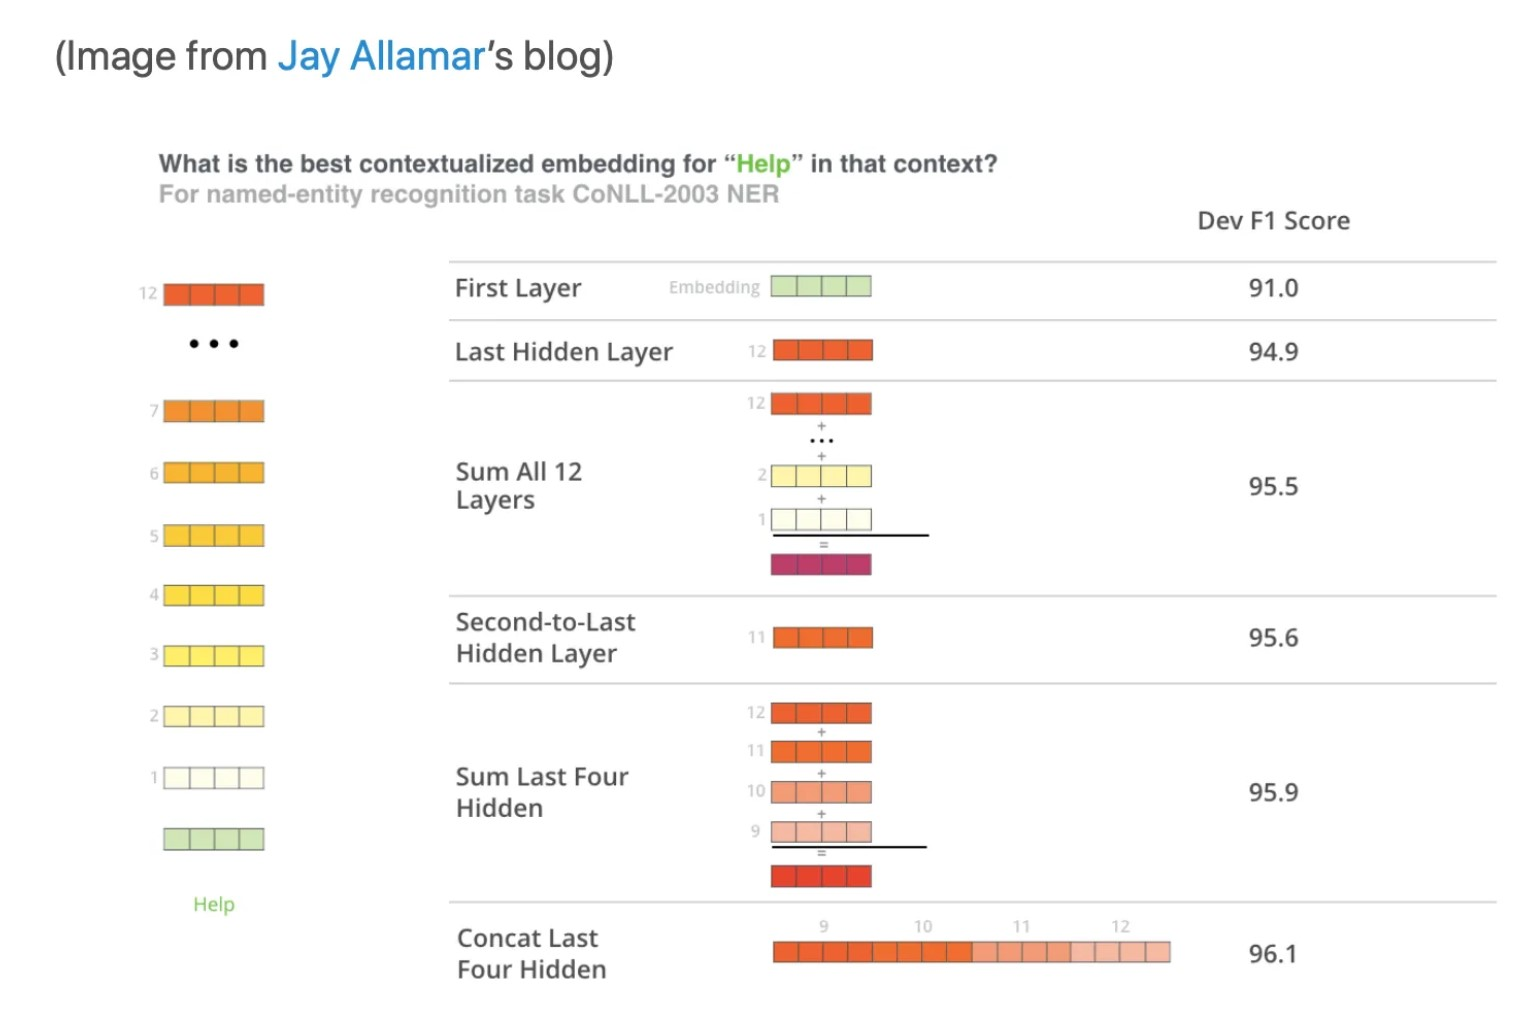

## Using Dense Passage Retrieval (DPR) from Hugginface


In [ ]:
from transformers import TFDPRReader, DPRReaderTokenizer

tokenizer = DPRReaderTokenizer.from_pretrained("facebook/dpr-reader-single-nq-base")
model = TFDPRReader.from_pretrained("facebook/dpr-reader-single-nq-base", from_pt=True)
encoded_inputs = tokenizer(eng_texts , return_tensors="tf")

outputs = model(encoded_inputs)
start_logits = outputs.start_logits
end_logits = outputs.end_logits
relevance_logits = outputs.relevance_logits